# Decision tree

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [2]:
# Read data file
full_df = pd.read_csv("../Data-Collisions.csv", low_memory=False)
full_df.head()

,SEVERITYCODE,X,Y,OBJECTID,INCKEY,COLDETKEY,REPORTNO,STATUS,ADDRTYPE,INTKEY,...,ROADCOND,LIGHTCOND,PEDROWNOTGRNT,SDOTCOLNUM,SPEEDING,ST_COLCODE,ST_COLDESC,SEGLANEKEY,CROSSWALKKEY,HITPARKEDCAR
0,2,-122.323148,47.703140,1,1307,1307,3502005,Matched,Intersection,37475.0,...,Wet,Daylight,NaN,NaN,NaN,10,Entering at angle,0,0,N
1,1,-122.347294,47.647172,2,52200,52200,2607959,Matched,Block,NaN,...,Wet,Dark - Street Lights On,NaN,6354039.0,NaN,11,From same direction - both going straight - bo...,0,0,N
2,1,-122.334540,47.607871,3,26700,26700,1482393,Matched,Block,NaN,...,Dry,Daylight,NaN,4323031.0,NaN,32,One parked--one moving,0,0,N
3,1,-122.334803,47.604803,4,1144,1144,3503937,Matched,Block,NaN,...,Dry,Daylight,NaN,NaN,NaN,23,From same direction - all others,0,0,N
4,2,-122.306426,47.545739,5,17700,17700,1807429,Matched,Intersection,34387.0,...,Wet,Daylight,NaN,4028032.0,NaN,10,Entering at angle,0,0,N


In [237]:
df = full_df[['SEVERITYCODE','WEATHER','ROADCOND','LIGHTCOND']]
df = df[df['WEATHER'] != 'Unknown']
df = df[df['ROADCOND'] != 'Unknown']
df = df[df['LIGHTCOND'] != 'Unknown']
df['SEVERITYCODE'].value_counts()
full_df['LIGHTCOND'].value_counts()

Daylight                    116137
Dark - Street Lights On      48507
Unknown                      13473
Dusk                          5902
Dawn                          2502
Dark - No Street Lights       1537
Dark - Street Lights Off      1199
Other                          235
Dark - Unknown Lighting         11
Name: LIGHTCOND, dtype: int64

In [135]:
# Downsample

df_1 = df[df['SEVERITYCODE']==1]
df_2 = df[df['SEVERITYCODE']==2]

df_1_downsampled = df_1.sample(n=55851)

df = pd.concat([df_1_downsampled,df_2]).reset_index()
df['SEVERITYCODE'].value_counts()



2    55851
1    55851
Name: SEVERITYCODE, dtype: int64

In [238]:
df = df.dropna(subset=['SEVERITYCODE','WEATHER','LIGHTCOND','ROADCOND'])

In [137]:
df['SEVERITYCODE'].value_counts()

2    55851
1    55851
Name: SEVERITYCODE, dtype: int64

In [33]:
df.dtypes

index            int64
SEVERITYCODE     int64
WEATHER         object
ROADCOND        object
LIGHTCOND       object
dtype: object

In [239]:
X = df[['WEATHER','ROADCOND','LIGHTCOND']].values
y = df[['SEVERITYCODE']].values
X

array([['Overcast', 'Wet', 'Daylight'],
       ['Raining', 'Wet', 'Dark - Street Lights On'],
       ['Overcast', 'Dry', 'Daylight'],
       ...,
       ['Clear', 'Dry', 'Daylight'],
       ['Clear', 'Dry', 'Dusk'],
       ['Clear', 'Wet', 'Daylight']], dtype=object)

In [263]:
df1 = pd.concat([df,\
                 pd.get_dummies(df['WEATHER'],prefix='weather'), \
                 pd.get_dummies(df['LIGHTCOND'],prefix='light'), \
                 pd.get_dummies(df['ROADCOND'],prefix='road')
                ], axis=1)
df_X = df1.drop(columns=['WEATHER','LIGHTCOND','ROADCOND','SEVERITYCODE'])
X2 = df_X.values

In [139]:
#df1 = pd.concat([df,\
#                 pd.get_dummies(df['WEATHER'],prefix='weather'), \
#                 pd.get_dummies(df['LIGHTCOND'],prefix='light'), \
#                 pd.get_dummies(df['ROADCOND'],prefix='road')
#                ], axis=1)
#df_X = df1.drop(columns=['WEATHER','LIGHTCOND','ROADCOND','SEVERITYCODE'])
#X = df_X.values
#y = df1[['SEVERITYCODE']].values

le_weather = preprocessing.LabelEncoder()
le_weather.fit(df['WEATHER'].get_values().tolist())
X[:,0] = le_weather.transform(X[:,0])

roadconds = df['ROADCOND'].get_values().tolist()
le_road = preprocessing.LabelEncoder()
le_road.fit(roadconds)
X[:,1] = le_road.transform(X[:,1])

le_light = preprocessing.LabelEncoder()
le_light.fit(df['LIGHTCOND'].get_values().tolist())
X[:,2] = le_light.transform(X[:,2])

X



array([[4, 0, 5],
       [9, 7, 2],
       [1, 0, 5],
       ...,
       [1, 0, 5],
       [1, 0, 5],
       [1, 0, 6]], dtype=object)

## Normalization

In [241]:
X2 = preprocessing.StandardScaler().fit(X2).transform(X2.astype(float))
X2

/Users/Katie/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype uint8 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


array([[-0.02, -1.33, -0.06, ..., -0.07, -0.03,  1.63],
       [-0.02, -1.33, -0.06, ..., -0.07, -0.03,  1.63],
       [-0.02, -1.33, -0.06, ..., -0.07, -0.03, -0.61],
       ...,
       [-0.02,  0.75, -0.06, ..., -0.07, -0.03, -0.61],
       [-0.02,  0.75, -0.06, ..., -0.07, -0.03, -0.61],
       [-0.02,  0.75, -0.06, ..., -0.07, -0.03,  1.63]])

## Train test split

In [265]:
X_train, X_test, y_train, y_test = train_test_split( X2, y, test_size=0.2, random_state=4)
print ('Train set:', X_train.shape,  y_train.shape)
print ('Test set:', X_test.shape,  y_test.shape)

Train set: (136408, 26) (136408, 1)
Test set: (34102, 26) (34102, 1)


In [266]:
X_train

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0]], dtype=uint8)

## Decision tree

### Training

In [267]:
k = 30
#Train Model and Predict  
weights = {1:1.0, 2:2}
crashTree = DecisionTreeClassifier(class_weight=weights, criterion="entropy", max_depth = k)
crashTree.fit(X_train,y_train)

DecisionTreeClassifier(class_weight={1: 1.0, 2: 2}, criterion='entropy',
            max_depth=30, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

### Testing

In [268]:
yhat = crashTree.predict(X_test)
yhat

array([2, 1, 1, ..., 1, 2, 1])

In [124]:
# Notice: You might need to uncomment and install the pydotplus and graphviz libraries if you have not installed these before
#!conda install -c conda-forge pydotplus -y
#!conda install -c conda-forge python-graphviz -y

Solving environment: done

## Package Plan ##

  environment location: /Users/Katie/anaconda3

  added / updated specs:
    - pydotplus


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    conda-4.9.0                |   py37h2987424_1         3.0 MB  conda-forge
    pydotplus-2.0.2            |     pyhd1c1de3_3          23 KB  conda-forge
    python_abi-3.7             |          1_cp37m           4 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         3.1 MB

The following NEW packages will be INSTALLED:

  pydotplus          conda-forge/noarch::pydotplus-2.0.2-pyhd1c1de3_3
  python_abi         conda-forge/osx-64::python_abi-3.7-1_cp37m

The following packages will be UPDATED:

  conda                                       4.7.11-py37_0 --> 4.9.0-py37h2987424_1



conda-4.9.0          | 3.0 MB    | #######

In [125]:
from sklearn.externals.six import StringIO
import pydotplus
import matplotlib.image as mpimg
from sklearn import tree
%matplotlib inline 

In [179]:
df_X.columns.values

array(['weather_Blowing Sand/Dirt', 'weather_Clear',
       'weather_Fog/Smog/Smoke', 'weather_Other', 'weather_Overcast',
       'weather_Partly Cloudy', 'weather_Raining',
       'weather_Severe Crosswind', 'weather_Sleet/Hail/Freezing Rain',
       'weather_Snowing', 'light_Dark - No Street Lights',
       'light_Dark - Street Lights Off', 'light_Dark - Street Lights On',
       'light_Dark - Unknown Lighting', 'light_Dawn', 'light_Daylight',
       'light_Dusk', 'light_Other', 'road_Dry', 'road_Ice', 'road_Oil',
       'road_Other', 'road_Sand/Mud/Dirt', 'road_Snow/Slush',
       'road_Standing Water', 'road_Wet'], dtype=object)

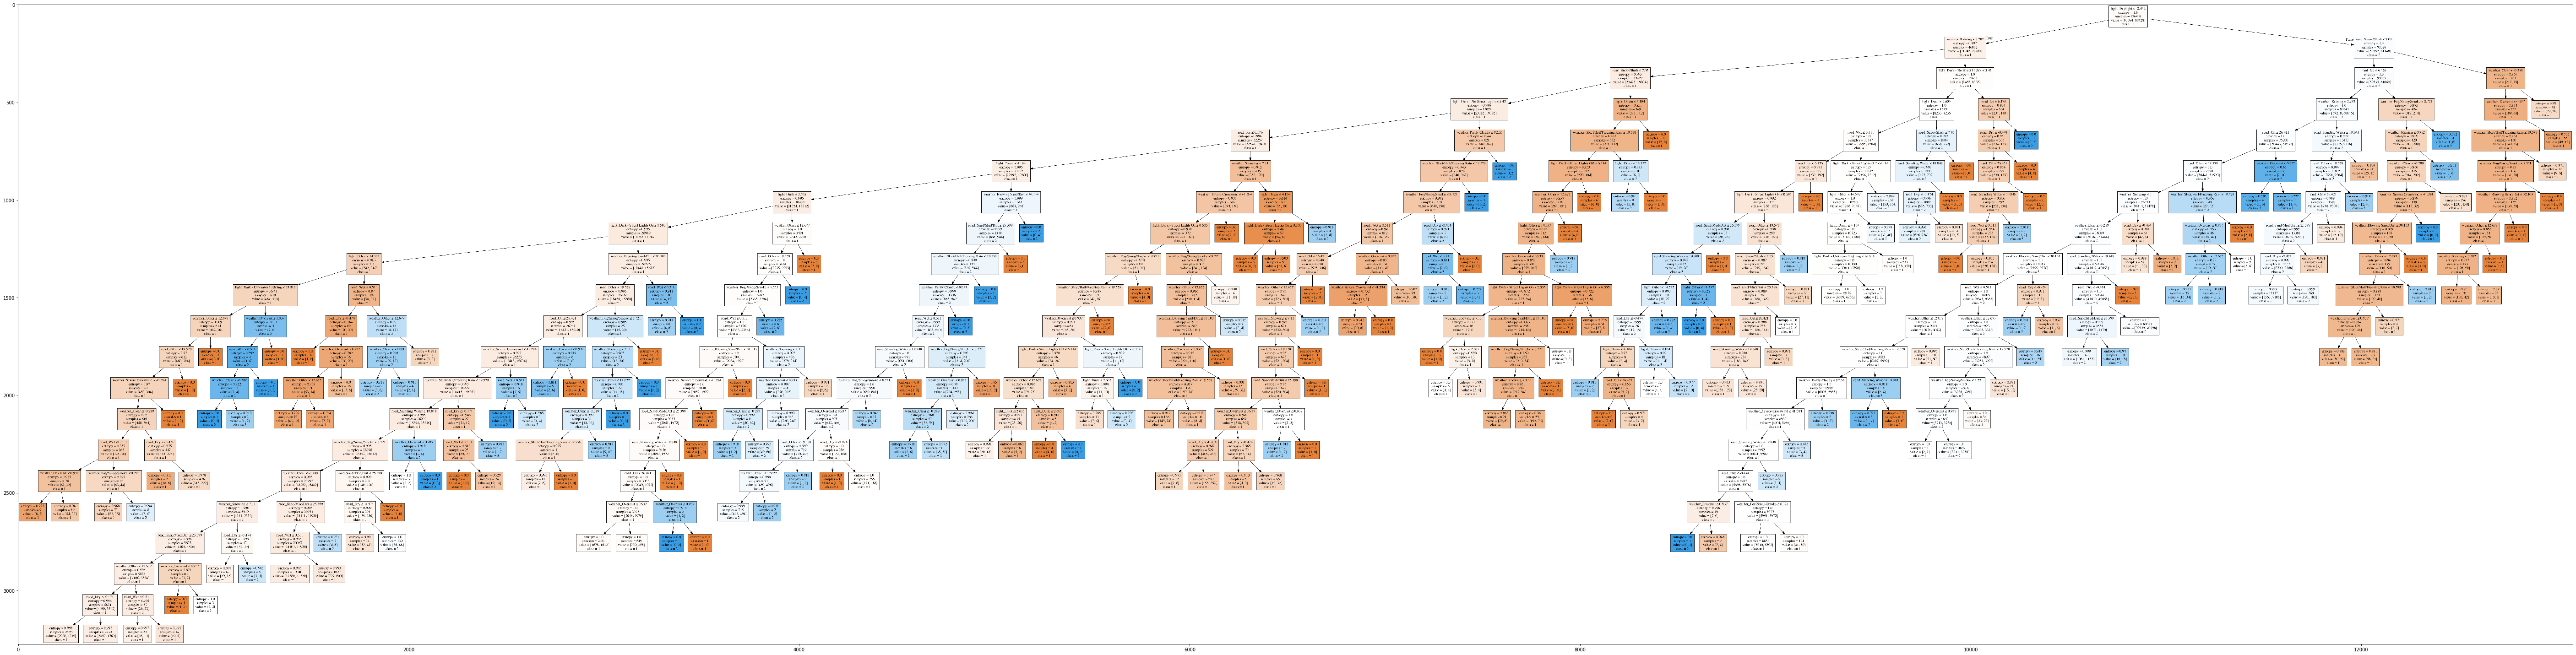

In [255]:
dot_data = StringIO()
filename = "crashtree.png"
featureNames = df_X.columns.values
targetNames = df["SEVERITYCODE"].unique().tolist()
out=tree.export_graphviz(crashTree,feature_names=featureNames, out_file=dot_data, class_names= ['1','2'], filled=True,  special_characters=True,rotate=False)  
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_png(filename)
img = mpimg.imread(filename)
plt.figure(figsize=(100, 200))
plt.imshow(img,interpolation='nearest')

### Accuracy evaluation

We begin with the nice confusion matrix plotting from the lab on Machine Learning / logistic regression.

In [226]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [260]:
print("Train set Accuracy: ", metrics.accuracy_score(y_train, crashTree.predict(X_train)))
print("Test set Accuracy: ", metrics.accuracy_score(y_test, yhat))

Train set Accuracy:  0.47843968095712863
Test set Accuracy:  0.47683420327253534


Confusion matrix, without normalization
[[ 9238 13727]
 [ 4113  7024]]


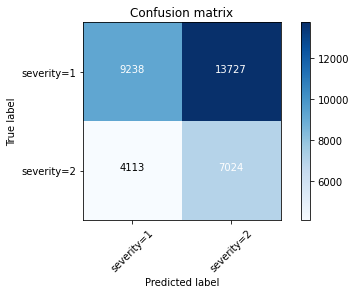

In [269]:
cnf_matrix = confusion_matrix(y_test, yhat, labels=[1,2])
np.set_printoptions(precision=2)


# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['severity=1','severity=2'],normalize= False,  title='Confusion matrix')